<a href="https://colab.research.google.com/github/WenyiYao/covtype/blob/main/transformer_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_nlp
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import numpy as np

Using TensorFlow backend


In [2]:
df = pd.read_json('USDC-ETH.json')
df.head()

,id,high,low,tvlUSD,txCount,volumeUSD,date,open,tick,close
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19251,1483.170696,1396.900687,2.517911e+08,11053,4.784684e+08,2022-09-16,1472.111248,203641,1433.463152
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19252,1476.144985,1402.098845,2.666791e+08,9014,2.088181e+08,2022-09-17,1433.463152,203394,1469.404359
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19253,1469.421851,1324.864844,2.485486e+08,10707,2.443570e+08,2022-09-18,1469.404359,204359,1334.321067
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19254,1392.051034,1274.907911,2.609486e+08,13410,3.697855e+08,2022-09-19,1334.321067,204053,1375.641442
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19255,1383.911802,1313.997663,2.540213e+08,11117,3.349061e+08,2022-09-20,1375.641442,204440,1322.192169


In [3]:
df = df.drop(columns=["id"])
df = df.set_index(['date'])
df.head()

,high,low,tvlUSD,txCount,volumeUSD,open,tick,close
date,,,,,,,,
2022-09-16,1483.170696,1396.900687,2.517911e+08,11053,4.784684e+08,1472.111248,203641,1433.463152
2022-09-17,1476.144985,1402.098845,2.666791e+08,9014,2.088181e+08,1433.463152,203394,1469.404359
2022-09-18,1469.421851,1324.864844,2.485486e+08,10707,2.443570e+08,1469.404359,204359,1334.321067
2022-09-19,1392.051034,1274.907911,2.609486e+08,13410,3.697855e+08,1334.321067,204053,1375.641442
2022-09-20,1383.911802,1313.997663,2.540213e+08,11117,3.349061e+08,1375.641442,204440,1322.192169


In [4]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'])])
fig.show()

In [5]:
dataset = df.values
dataset

array([[1.48317070e+03, 1.39690069e+03, 2.51791059e+08, ...,
        1.47211125e+03, 2.03641000e+05, 1.43346315e+03],
       [1.47614498e+03, 1.40209885e+03, 2.66679134e+08, ...,
        1.43346315e+03, 2.03394000e+05, 1.46940436e+03],
       [1.46942185e+03, 1.32486484e+03, 2.48548636e+08, ...,
        1.46940436e+03, 2.04359000e+05, 1.33432107e+03],
       ...,
       [1.91744262e+03, 1.87164646e+03, 4.21586684e+08, ...,
        1.89410228e+03, 2.00821000e+05, 1.90038819e+03],
       [1.90651873e+03, 1.85254812e+03, 4.21238435e+08, ...,
        1.90038819e+03, 2.00893000e+05, 1.88681227e+03],
       [1.90372155e+03, 1.87535372e+03, 4.25635507e+08, ...,
        1.88681227e+03, 2.00841000e+05, 0.00000000e+00]])

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [7]:
def create_sequence(dataset, sequence_length=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-sequence_length-1):
        a = dataset[i:(i+sequence_length)]
        dataX.append(a)
        dataY.append(dataset[i+sequence_length,[0,1,7]]) #predict high, low, and close
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [9]:
sequence_length = 4
trainX, trainY = create_sequence(train, sequence_length)
testX, testY = create_sequence(test, sequence_length)

In [10]:
print(trainX.shape)
print(trainY.shape)

(288, 4, 8)
(288, 3)


In [11]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [12]:
batch_size = 8
epochs=10

model1 = keras.Sequential([
    layers.Input(shape=(sequence_length, 8)),
    keras_nlp.layers.TransformerEncoder(num_heads=5, intermediate_dim=32),
    layers.GlobalAveragePooling1D(),
    layers.Dense(3) # output layer with 3 units for close, high and open value
])

model1.compile(loss='mean_squared_error', optimizer='adam')

#history = model1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=2, shuffle=False)

In [13]:
validation_size = int(len(trainX) * 0.1)
validationX, validationY = trainX[-validation_size:], trainY[-validation_size:]
trainX = trainX[:-validation_size]
trainY = trainY[:-validation_size]

In [14]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Lists to store training loss at the end of each iteration
training_loss = []
validation_loss = []

iterations = 7
epochs = 10

# Training loop
for iteration in range(iterations):
    print(f"Iteration {iteration + 1}/{iterations}")

    # Train the model with early stopping
    history = model1.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_data=(validationX, validationY),
                         verbose=2, shuffle=False, callbacks=[early_stopping])

    # Store the training loss at the end of each iteration
    #training_loss.extend(history.history['loss'])
    training_loss.extend([loss * 10000 for loss in history.history['loss']])
    #validation_loss.extend(history.history['val_loss'])
    validation_loss.extend([loss * 10000 for loss in history.history['val_loss']])

Iteration 1/7
Epoch 1/10
33/33 - 8s - loss: 0.9905 - val_loss: 0.4765 - 8s/epoch - 254ms/step
Epoch 2/10
33/33 - 0s - loss: 0.2443 - val_loss: 0.0724 - 270ms/epoch - 8ms/step
Epoch 3/10
33/33 - 0s - loss: 0.1083 - val_loss: 0.0427 - 262ms/epoch - 8ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0472 - val_loss: 0.0230 - 259ms/epoch - 8ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0262 - val_loss: 0.0142 - 229ms/epoch - 7ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0174 - val_loss: 0.0100 - 199ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0133 - val_loss: 0.0080 - 214ms/epoch - 6ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0114 - val_loss: 0.0070 - 196ms/epoch - 6ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0102 - val_loss: 0.0063 - 192ms/epoch - 6ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0094 - val_loss: 0.0059 - 188ms/epoch - 6ms/step
Iteration 2/7
Epoch 1/10
33/33 - 0s - loss: 0.0086 - val_loss: 0.0055 - 380ms/epoch - 12ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0080 - val_loss: 0.0052 - 268ms/epoch - 8ms/step

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_encoder (Trans  (None, 4, 8)              767       
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 3)                 27        
                                                                 
Total params: 794 (3.10 KB)
Trainable params: 794 (3.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


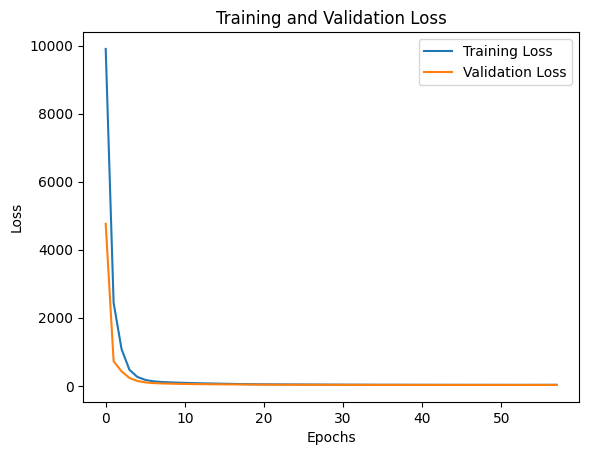

In [16]:
# Plot training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
trainPredict = model1.predict(trainX, batch_size=batch_size)
trainScore = math.sqrt(mean_squared_error(trainY[:, 0], trainPredict[:, 0]))
print('Train Score of high value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainY[:, 1], trainPredict[:, 1]))
print('Train Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainY[:, 2], trainPredict[:, 2]))
print('Train Score of close value: %.10f RMSE' % (trainScore))

33/33 [==============================] - 0s 3ms/step
Train Score of high value: 0.0676228722 RMSE
Train Score of low value: 0.0598303671 RMSE
Train Score of close value: 0.0357322741 RMSE


In [18]:
testPredict = model1.predict(testX, batch_size=batch_size)
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:, 0]))
print('Test Score of high value: %.10f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(testY[:, 1], testPredict[:, 1]))
print('Test Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(testY[:, 2], testPredict[:, 2]))
print('Test Score of close value: %.10f RMSE' % (trainScore))

16/16 [==============================] - 0s 3ms/step
Test Score of high value: 0.0581195552 RMSE
Test Score of low value: 0.0367371388 RMSE
Test Score of close value: 0.0361488997 RMSE


In [19]:
print(trainPredict.shape)
print(trainY.shape)

(260, 3)
(260, 3)


In [20]:
print(testPredict.shape)
print(testY.shape)

(121, 3)
(121, 3)


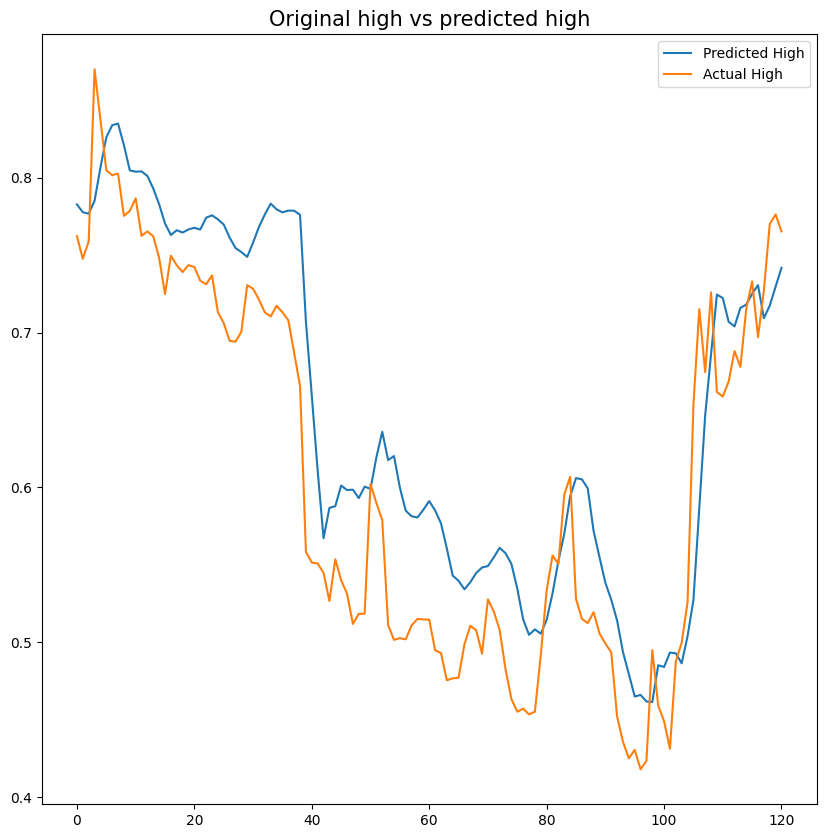

In [21]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 0], label=("Predicted High"))
plt.plot(testY[:, 0], label=("Actual High"))
plt.title('Original high vs predicted high', fontsize=15)
plt.legend()
plt.show()

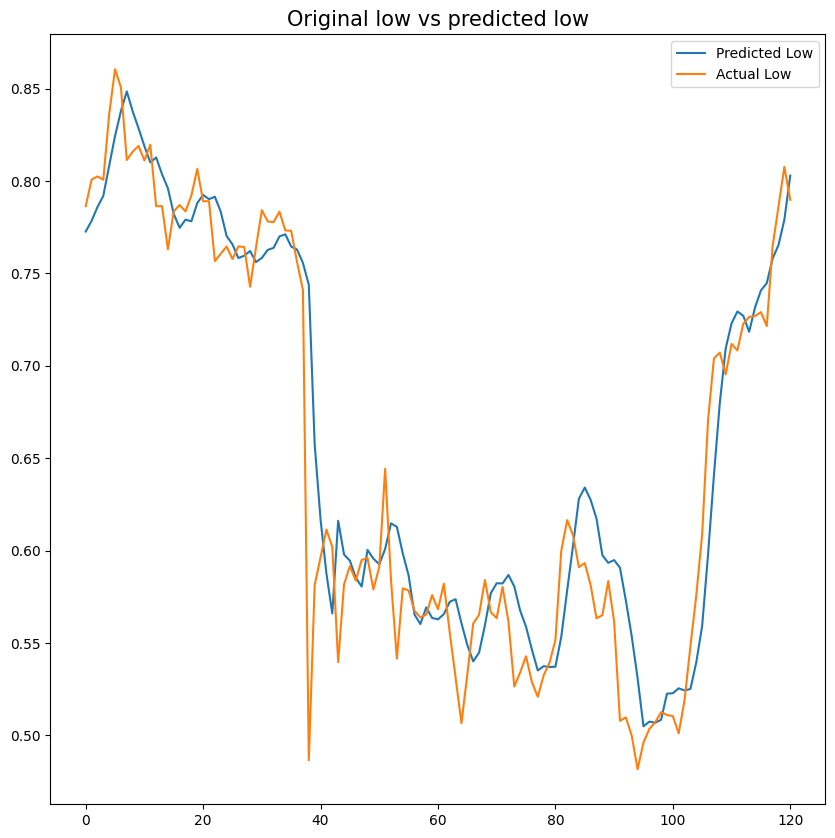

In [22]:
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 1], label=("Predicted Low"))
plt.plot(testY[:, 1],label=("Actual Low"))
plt.title('Original low vs predicted low', fontsize=15)
plt.legend()
plt.show()

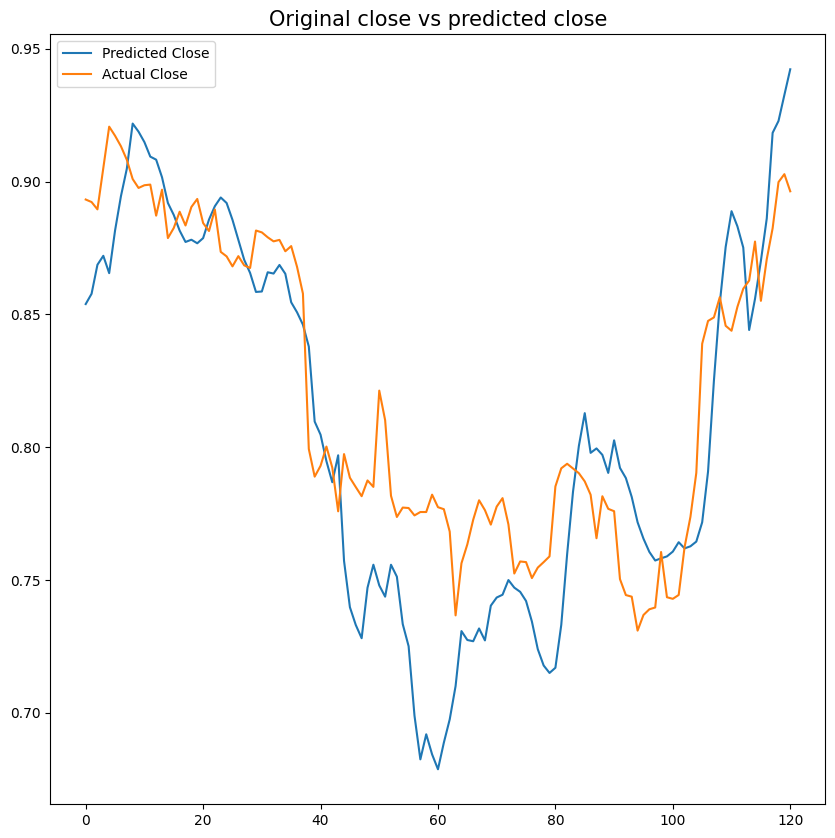

In [23]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], 2], label=("Predicted Close"))
plt.plot(testY[:, 2], label=("Actual Close"))
plt.title('Original close vs predicted close', fontsize=15)
plt.legend()
plt.show()

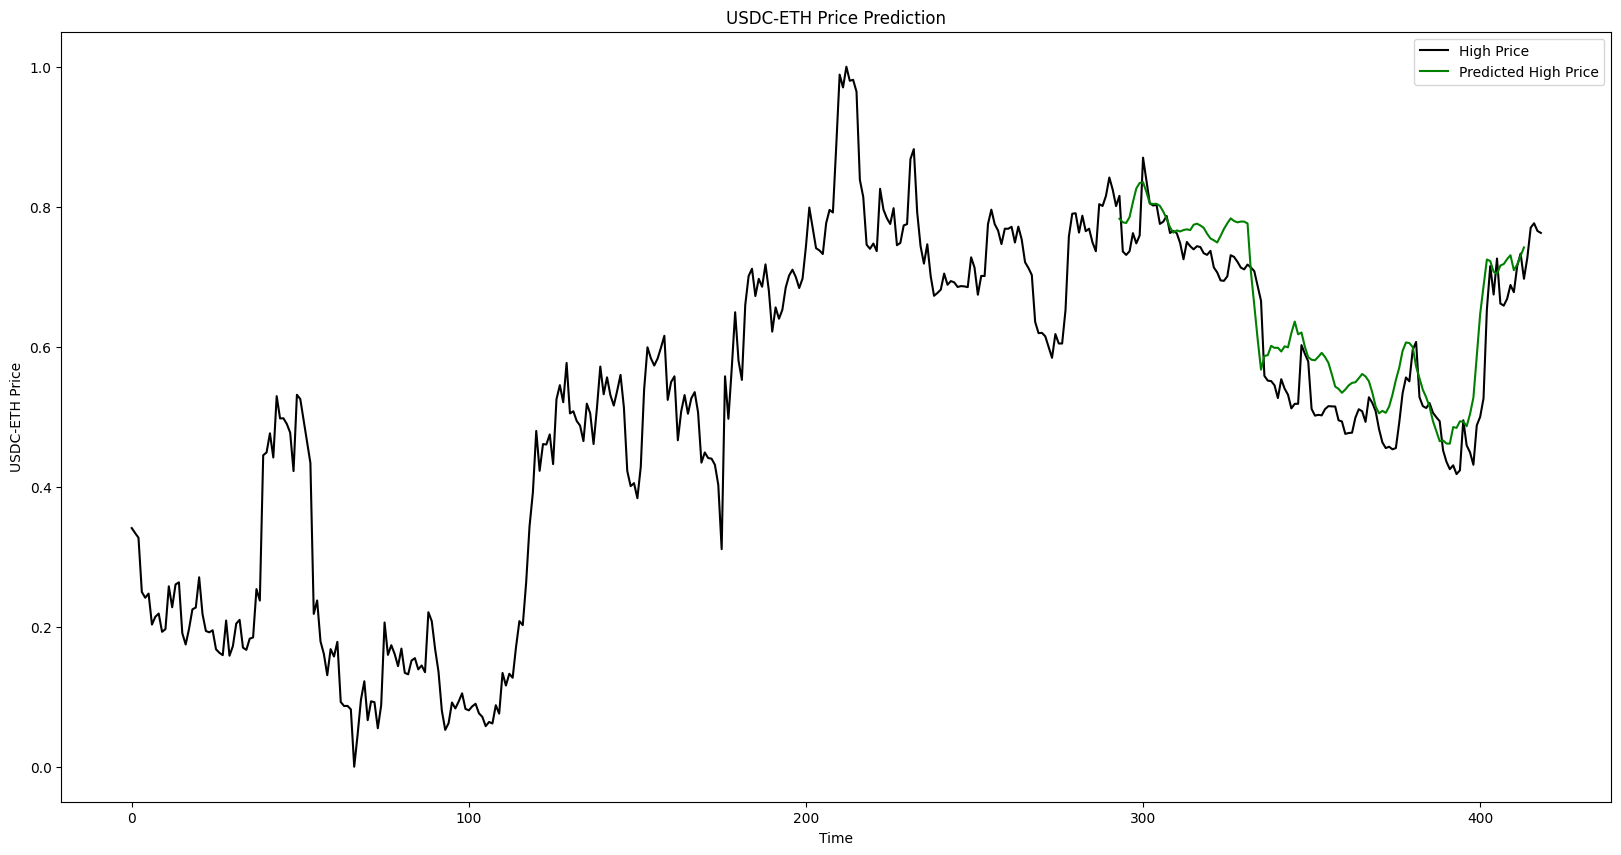

In [24]:
date_index = train_size
plt.figure(figsize=(20, 10))
plt.plot(dataset[:,0], color = 'black', label = 'High Price')
plt.plot(range(date_index, date_index + len(testPredict)), testPredict[:, 0], color = 'green', label = 'Predicted High Price')
plt.title('USDC-ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('USDC-ETH Price')
plt.legend()
plt.show()
